In [1]:
import numpy as np 
import pandas as pd 
import os
PARAMS_VIDEO={
    'shape':(256,256),
    'is_face':True,
    'is_first_face':False,
    'is_first':False,
    'on_each':30,
}

In [2]:
!pip install /kaggle/input/efficientnet/efficientnet-1.0.0-py3-none-any.whl

Processing /kaggle/input/efficientnet/efficientnet-1.0.0-py3-none-any.whl


In [3]:
!pip install /kaggle/input/mtcnn-package/mtcnn-0.1.0-py3-none-any.whl

Processing /kaggle/input/mtcnn-package/mtcnn-0.1.0-py3-none-any.whl


In [4]:
import efficientnet.keras as efn

Using TensorFlow backend.


In [5]:
import os
import cv2
import sys
import pandas as pd
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [6]:
DATA_DIR='/kaggle/input/deepfake-detection-challenge/'
TRAIN_DIR=f'{DATA_DIR}train_sample_videos/'
TEST_DIR=f'{DATA_DIR}test_videos/'
SUB_DIR=f'{DATA_DIR}sample_submission.csv'

FACE_DETECTION_FOLDER=f'/kaggle/input/haar-cascades-for-face-detection/'
FACENET_DIR=f'/kaggle/input/facenet-keras/'

In [7]:
class ObjectDetector():
   
    def __init__(self,object_cascade_path):
       

        self.objectCascade=cv2.CascadeClassifier(object_cascade_path)


    def detect(self, image, scale_factor=1.3,
               min_neighbors=5,
               min_size=(20,20)):
     
        rects=self.objectCascade.detectMultiScale(image,
                                                scaleFactor=scale_factor,
                                                minNeighbors=min_neighbors,
                                                minSize=min_size)
        return rects

In [8]:
import json
f=open(TRAIN_DIR+'metadata.json')
train_labels=json.loads(f.read())

def json2pd(jdata):
    res=[]
    for k in jdata.keys():
        jdata[k]['name']=k
        res.append(jdata[k])
    return pd.DataFrame(res)

train_labels=json2pd(train_labels)

In [9]:
import gc
import sys

def get_obj_size(obj):
    marked = {id(obj)}
    obj_q = [obj]
    sz = 0

    while obj_q:
        sz += sum(map(sys.getsizeof, obj_q))
        all_refr = ((id(o), o) for o in gc.get_referents(*obj_q))
        new_refr = {o_id: o for o_id, o in all_refr if o_id not in marked and not isinstance(o, type)}
        obj_q = new_refr.values()
        marked.update(new_refr.keys())

    return sz

In [10]:
from mtcnn import MTCNN

In [11]:
face_detect=MTCNN()

In [12]:
dir(face_detect)

['_MTCNN__bbreg',
 '_MTCNN__compute_scale_pyramid',
 '_MTCNN__generate_bounding_box',
 '_MTCNN__nms',
 '_MTCNN__pad',
 '_MTCNN__rerec',
 '_MTCNN__scale_image',
 '_MTCNN__stage1',
 '_MTCNN__stage2',
 '_MTCNN__stage3',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_min_face_size',
 '_onet',
 '_pnet',
 '_rnet',
 '_scale_factor',
 '_steps_threshold',
 'detect_faces',
 'min_face_size']

In [13]:
def detect_objects(image, scale_factor=1.3, min_neighbors=5, min_size=(50,50)):
    
    image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    eyes=eye_detector.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=(int(min_size[0]/2), int(min_size[1]/2)))

    for x, y, w, h in eyes:
      
        cv2.circle(image,(int(x+w/2),int(y+h/2)),(int((w + h)/4)),(0, 0,255),3)
 

    profiles=profile_detector.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=min_size)

    for x, y, w, h in profiles:
       
        cv2.rectangle(image,(x,y),(x+w, y+h),(255, 0,0),3)

    faces=front_detector.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=min_size)

    for x, y, w, h in faces:
        
        cv2.rectangle(image,(x,y),(x+w, y+h),(0, 255,0),3)

   
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)

In [14]:
def get_face(image, scale_factor=2,preshape=(512,512), min_neighbors=5, min_size=(30,30),target_shape=(256,256)):
    
    image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if(preshape):
        image_gray=cv2.resize(image_gray,preshape)

    profiles=profile_detector.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=min_size)

    faces=front_detector.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=min_size)
    res_faces=[]
    if(len(profiles)!=0 or len(faces)!=0):
        for p in profiles:
            im=image[p[1]:p[1]+p[3],p[0]:p[0]+p[2]]
            if(target_shape):
                im=cv2.resize(im,target_shape, interpolation = cv2.INTER_AREA)
            res_faces.append(im)
        for p in faces:
            im=image[p[1]:p[1]+p[3],p[0]:p[0]+p[2]]
            if(target_shape):
                im=cv2.resize(im,target_shape, interpolation = cv2.INTER_AREA)
            res_faces.append(im)
    filtered_faces=[]        
    if(len(res_faces)!=0):
        for f in res_faces:
            eyes=eye_detector.detect(f,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=(int(min_size[0]/2), int(min_size[1]/2)))
            if(len(eyes)!=0):
                filtered_faces.append(f)
    #features=model.predict(np.array(filtered_faces))
    return filtered_faces

In [15]:
def get_face(image, scale_factor=2,preshape=(256,256), target_shape=(256,256)):

    original_shape=image.shape
    if(preshape):
        scale_y=original_shape[0]/preshape[0]
        scale_x=original_shape[1]/preshape[1]
        reshape_image=cv2.resize(image,preshape)
    else:
        scale_y=1
        scale_x=1
        reshape_image=image
    
    par_faces=face_detect.detect_faces(reshape_image)
    
    faces=[]
    
    
    for p in par_faces:
        width=int(p['box'][2]*scale_x)
        height=int(p['box'][3]*scale_y)
        new_width=int(width*scale_factor)
        new_height=int(height*scale_factor)
        x=int(p['box'][0]*scale_x)-(new_width-width)//2
        y=int(p['box'][1]*scale_y)-(new_height-height)//2
        if(x<0):
            x=0
        if(y<0):
            y=0
        
        try:
            if(x+width<image.shape[1] and y+height<image.shape[0] and new_width!=0 and new_height!=0):
                face=image[y:y+new_width,x:x+new_width]
                if(target_shape):
                    face=cv2.resize(face,target_shape)
                faces.append(face)
            
        except:
            print('error',p)

    return faces

In [16]:
class VideoReader():
    def __init__(self,video_path,shape=None,is_gray=False,is_face=False,is_dif=False,is_first=False,is_first_face=False,on_each=1,offset=0):
        self.video_path=video_path
        self.codec=cv2.VideoCapture(self.video_path)
        self.shape=shape
        
        self.stop_read=False
        
        self.cur_ind=0
        
        self.is_gray=is_gray
        self.is_face=is_face
        self.is_dif=is_dif
        self.is_first=is_first
        self.is_first_face=is_first_face
        self.on_each=on_each
        self.offset=offset
        
        self.is_error=False
        
        self.frames=[]
        self.frames_vector=[]
        
        
        self.dif_frames=[]
        self.first_frame=None
        self.last_frame=None
        
        self.faces=[]
        self.miss_faces=[]
        
        
        self.params={}
        
        self.dif_params={
            'mse':[],
            'ssim':[],
        }
    
    def get_video(self):
        while(self.codec.isOpened() and not self.stop_read):
            self.on_frame()
        #self.get_params()
        
    def on_frame(self):
        ret, frame = self.codec.read()
        if (ret==True and self.cur_ind>=self.offset):
            if(type(frame)!=type(None) ):
                if((self.cur_ind+1)%self.on_each==0):
                    #frame=self.preprocess_frame(frame)
                    if(self.is_face):
                        self.get_face(frame)
                    if(self.is_first):
                        self.stop_read=True
                    self.frames.append(frame)
        else:
            self.stop_read=True
        self.cur_ind+=1
            
    def get_face(self,frame):
        faces=get_face(frame,preshape=None,target_shape=self.shape)
        if(len(faces)>0):
            self.faces.append(faces)
            if(self.is_first_face):
                self.stop_read=True
        else:
            self.miss_faces.append(self.cur_ind)
        
            
    
    def get_params(self):
        self.params['fname']=self.video_path
        self.params['length']=len(self.frames)
        self.params['size_obj']=get_obj_size(self)
        
    def preprocess_frame(self,frame):
        if(self.shape):
            frame=cv2.resize(frame,(self.shape[1],self.shape[0]))
        if(self.is_gray):
            frame=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        return frame
    

In [17]:
class VideoGroupReader():
    def __init__(self,original_file,list_fakes=[]):
        self.original_file=original_file
        self.list_fakes=list_fakes
    def dif_videos(self):
        for i in range(len(self.list_fakes)):
            fake=self.list_fakes[i]
            vr=VideoReader(fake,is_face=True,is_first_face=False,on_each=30)
        

In [18]:
frontal_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_frontalface_default.xml')
eye_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_eye.xml')
profile_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_profileface.xml')
smile_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_smile.xml')

print(eye_cascade_path)

front_detector=ObjectDetector(frontal_cascade_path)

eye_detector=ObjectDetector(eye_cascade_path)

profile_detector=ObjectDetector(profile_cascade_path)

smile_detector=ObjectDetector(smile_cascade_path)

/kaggle/input/haar-cascades-for-face-detection/haarcascade_eye.xml


In [19]:
train_files=os.listdir(TRAIN_DIR)
test_files=os.listdir(TEST_DIR)
for k in train_files:
    if('.json' in k):
        json_file=k
        train_files.remove(k)

In [20]:
len(train_files),len(test_files),json_file

(400, 400, 'metadata.json')

In [21]:
import json
f=open(TRAIN_DIR+json_file)
train_label=json.loads(f.read())

In [22]:
train_label['dkzvdrzcnr.mp4']

{'label': 'REAL', 'split': 'train', 'original': None}

In [23]:
import cv2
import matplotlib.pyplot as plt
import keras

In [24]:
from keras.utils import Sequence
from skimage.measure import compare_ssim

In [25]:
!mkdir face_data

In [26]:
#train_data_x=[]
train_data_y=[]
bad_names=[]
train_decode_data={}
for i in tqdm(range(len(train_files))):
    video = VideoReader(TRAIN_DIR+train_files[i],shape=PARAMS_VIDEO['shape'],is_face=PARAMS_VIDEO['is_face'],is_first_face=PARAMS_VIDEO['is_first_face'],is_first=PARAMS_VIDEO['is_first'],on_each=PARAMS_VIDEO['on_each'])
    video.get_video()
    label=int(train_label[train_files[i]]['label']=='FAKE')
    start_ind=len(train_data_y)
    
    for j in range(len(video.faces)):
        if(len(video.faces[j])==1):
            
            #train_data_x+=video.faces[j]
            for t in range(len(video.faces[j])):
                #print(video.faces[j][t].shape)
                fname=f'face_data/{train_files[i]}_{j}_{t}_{label}.png'
                cv2.imwrite(fname,video.faces[j][t])
                if(train_files[i] in train_decode_data.keys()):
                    train_decode_data[train_files[i]].append(fname)
                else:
                    train_decode_data[train_files[i]]=[fname]
            #train_data_y+=[label] * (len(video.faces[j]))
    if(len(video.faces)==0):
        bad_names.append(train_files[i])
    

In [27]:
bad_names

['eoewqcpbgt.mp4',
 'andaxzscny.mp4',
 'dkhlttuvmx.mp4',
 'atvmxvwyns.mp4',
 'dqnyszdong.mp4',
 'axwgcsyphv.mp4',
 'avvdgsennp.mp4',
 'bbvgxeczei.mp4',
 'cwqlvzefpg.mp4',
 'djvutyvaio.mp4']

In [28]:
import skimage.filters
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, files,data,jdata=None,len_frames=300,batch_size=4,shuffle=True,dim=(1024,1024),channels=3,mode='fit'):
        self.dim = dim
        self.files=files
        self.data=data
        self.jdata=jdata
        self.len_frames=len_frames
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.dim=dim
        self.channels=channels
        self.mode=mode

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.files) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.files[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        x=np.zeros((self.batch_size,*self.dim,3),dtype=np.float32)
        for i in range(len(batch_files)):
           
            face = self.data[batch_files[i]][0]
            
            x[i,:,:]=face/255
        return x
    
    def __generate_y(self, batch_files):
        y=np.zeros((self.batch_size,1))
        for i in range(len(batch_files)):
            val=self.jdata[batch_files[i]]['label']=='FAKE'
            y[i]=val
        return y

In [29]:
import skimage.filters
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, data_files,data_dir='face_data',len_frames=300,batch_size=4,shuffle=True,dim=(1024,1024),channels=3,mode='fit'):
        self.dim = dim
        self.data_files=data_files
        #print(len(self.data_files))
        self.len_frames=len_frames
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.dim=dim
        self.channels=channels
        self.mode=mode
        self.data_dir=data_dir
        self.indexes = np.arange(len(self.data_files))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return (len(self.data_files) // self.batch_size)

    def __getitem__(self, index):

        batch_files = self.data_files[index*self.batch_size:(index+1)*self.batch_size]
       
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        x=np.zeros((self.batch_size,*self.dim,3),dtype=np.float32)
        
        for i in range(len(batch_files)):
            face = cv2.imread(f'{self.data_dir}/'+batch_files[i])
            #print('max=',np.max(face))
            x[i,]=face/255
        return x
    
    def __generate_y(self, batch_files):
        y=np.zeros((self.batch_size,2))
        for i in range(len(batch_files)):
           
            indxs=train_decode_data[batch_files[i].split('_')[0]]
            label=train_data_y[indxs[0]]
            y[i]=keras.utils.to_categorical(label,2)
           
        return y

In [30]:
import skimage.filters
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, data_files,data_dir='face_data',len_frames=300,batch_size=4,shuffle=True,dim=(1024,1024),channels=3,mode='fit'):
        self.dim = dim
        self.data_files=data_files
        #print(len(self.data_files))
        self.len_frames=len_frames
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.dim=dim
        self.channels=channels
        self.mode=mode
        self.data_dir=data_dir
        self.indexes = np.arange(len(self.data_files))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return (len(self.data_files) // self.batch_size)

    def __getitem__(self, index):

        batch_files = self.data_files[index*self.batch_size:(index+1)*self.batch_size]
       
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
       
        x=[]
        for i in range(len(batch_files)):
            cur_files=train_decode_data[batch_files[i]]
            for c in cur_files:
                
                face = cv2.imread(c)
                x.append(face/255)
            
        return np.array([x])
    
    def __generate_y(self, batch_files):
        y=np.zeros((self.batch_size,2))
        for i in range(len(batch_files)):
            cur_files=train_decode_data[batch_files[i]]
            
            label=int(cur_files[0].split('_')[-1].split('.')[0])
            
            y[i]=keras.utils.to_categorical(label,2)
            
        return y

In [31]:
bad_names

['eoewqcpbgt.mp4',
 'andaxzscny.mp4',
 'dkhlttuvmx.mp4',
 'atvmxvwyns.mp4',
 'dqnyszdong.mp4',
 'axwgcsyphv.mp4',
 'avvdgsennp.mp4',
 'bbvgxeczei.mp4',
 'cwqlvzefpg.mp4',
 'djvutyvaio.mp4']

In [32]:
new_train_files=[]
for i in range(len(train_files)):
    if(not (train_files[i] in bad_names)):
        if(train_files[i] in train_decode_data.keys()):
            if(len(train_decode_data[train_files[i]])!=0):
                new_train_files.append(train_files[i])

In [33]:
len(new_train_files)

388

In [34]:
from sklearn.model_selection import train_test_split
train_x,val_x  = train_test_split(new_train_files, test_size=0.15, random_state=42)

In [35]:
len(train_x),len(val_x)

(329, 59)

In [36]:
gen=DataGeneratorFull(train_x,dim=(256,256),batch_size=1)
val=DataGeneratorFull(val_x,dim=(256,256),batch_size=1)


In [37]:
%%time
g=gen.__getitem__(30)

CPU times: user 22.7 ms, sys: 2 ms, total: 24.7 ms
Wall time: 25.9 ms


In [38]:
g[0].shape

(1, 9, 256, 256, 3)

In [39]:
def build_lstm_model(input_shape=(300,256,256,1)):
    inp=keras.layers.Input(input_shape)
    #out1=keras.layers.ConvLSTM2D(16,3,return_sequences=True,activation='relu',padding='same')(inp)
    #out2=keras.layers.ConvLSTM2D(16,3,return_sequences=True,activation='relu',padding='same')(inp)
    #out=keras.layers.concatenate([out1,out2])

    #print(out.shape)
    #out=keras.layers.MaxPooling3D((1,2,2))(inp)
    out1=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.MaxPooling3D((1,2,2))(out)
    out1=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling3D()(out)
    out=keras.layers.Dense(1,activation='sigmoid')(out)

    model=keras.models.Model(input=inp,output=out)
    return model

In [40]:
def unet(input_size = (32,32,1),descr=1,classes=1,activation='sigmoid'):
    
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = keras.layers.Conv2D(classes*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = keras.layers.Conv2D(classes, 1, activation = activation)(conv9)
    
    model = keras.models.Model(input = inputs, output = conv10)
    
    return model

In [41]:
def build_lstm_model(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    
    unet_back=unet(input_size = input_shape,descr=8,classes=3,activation='relu')
    back=keras.applications.mobilenet.MobileNet(input_shape=input_shape,pooling='avg',include_top=False,weights=None)
    back.load_weights('/kaggle/input/mobilenet/mobilenet_1_0_224_tf_no_top.h5')
    out=unet_back(inp)
    
    out=keras.layers.Dense(512,activation='relu')(out)
    out=keras.layers.Dropout(0.5)(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model=keras.models.Model(input=inp,output=out)
    return model

In [42]:
def build_lstm_model(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=input_shape,include_top=False,weights=None,pooling='avg')
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
   
    out=back(inp)
    
    out=keras.layers.Dense(256,activation='relu')(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model=keras.models.Model(input=inp,output=out)
    return model

In [43]:
def build_lstm_model(input_shape=(None,256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=(256,256,3),include_top=False,weights=None,pooling=None)
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
   
    
    out=keras.layers.TimeDistributed(back)(inp)
    
    out1=keras.layers.ConvLSTM2D(128,3,activation='relu')(out)
    out2=keras.layers.ConvLSTM2D(128,3,go_backwards=True,activation='relu')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling2D()(out)
   
    out=keras.layers.Dense(2,activation='softmax')(out)

    model=keras.models.Model(input=inp,output=out)
    return model

In [44]:
model=build_lstm_model()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [45]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, 256, 25 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 8, 8, 1 4049564     input_4[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 6, 6, 128)    6488576     time_distributed_1[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)     (None, 6, 6, 128)    6488576     time_distributed_1[0][0]         
____________________________________________________________________________________________

In [46]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [47]:
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

In [48]:
history=model.fit_generator(gen,validation_data=val,verbose=1,epochs=10,callbacks=[check])



Epoch 1/10
329/329 [==============================] - 111s 337ms/step - loss: 1.7940 - acc: 0.7599 - val_loss: 0.2139 - val_acc: 0.7966
Epoch 2/10
329/329 [==============================] - 79s 240ms/step - loss: 0.6116 - acc: 0.7690 - val_loss: 0.0000e+00 - val_acc: 0.8136
Epoch 3/10
329/329 [==============================] - 80s 243ms/step - loss: 3.5564 - acc: 0.7295 - val_loss: 0.0000e+00 - val_acc: 0.8136
Epoch 4/10
329/329 [==============================] - 80s 243ms/step - loss: 20.5297 - acc: 0.6717 - val_loss: 0.0000e+00 - val_acc: 0.7797
Epoch 5/10
329/329 [==============================] - 80s 243ms/step - loss: 112.9225 - acc: 0.6839 - val_loss: 537.6003 - val_acc: 0.6610
Epoch 6/10
329/329 [==============================] - 80s 244ms/step - loss: 75.6002 - acc: 0.6687 - val_loss: 0.0000e+00 - val_acc: 0.7288
Epoch 7/10
329/329 [==============================] - 80s 244ms/step - loss: 35.6884 - acc: 0.6596 - val_loss: 0.0000e+00 - val_acc: 0.7966
Epoch 8/10
329/329 [=======

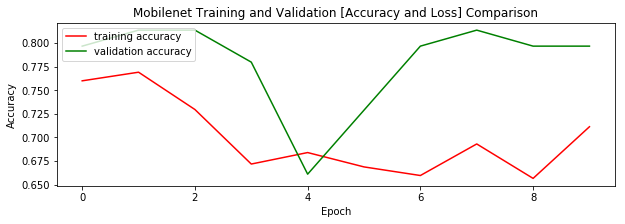

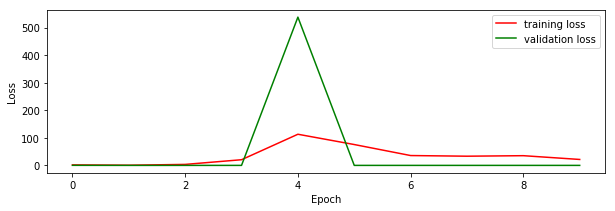

In [49]:
plt.figure(figsize=(10,3))
plt.title('Mobilenet Training and Validation [Accuracy and Loss] Comparison')
plt.plot(history.history['acc'],color='red', label='training accuracy')
plt.plot(history.history['val_acc'],color='green', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(history.history['loss'],color='red', label='training loss')
plt.plot(history.history['val_loss'],color='green', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

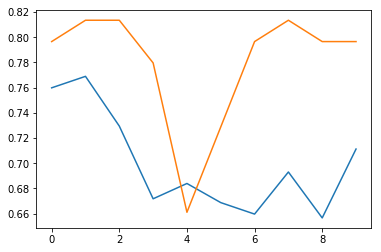

In [50]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [51]:
model.load_weights('res_weights.h5')

In [52]:
def build_lstm_model1(input_shape=(300,256,256,1)):
    inp=keras.layers.Input(input_shape)
   
    out1=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.MaxPooling3D((1,2,2))(out)
    out1=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling3D()(out)
    out=keras.layers.Dense(1,activation='sigmoid')(out)

    model1=keras.models.Model(input=inp,output=out)
    return model1

In [53]:
def unet(input_size = (32,32,1),descr=1,classes=1,activation='sigmoid'):
    #descr=2
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = keras.layers.Conv2D(classes*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    model1 = keras.models.Model(input = inputs, output = conv10)
    
    #model.summary()

    #if(pretrained_weights):
    	#model.load_weights(pretrained_weights)

    return model1

In [54]:
def build_lstm_model1(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    
    unet_back=unet(input_size = input_shape,descr=8,classes=3,activation='relu')
    back=keras.applications.mobilenet.MobileNet(input_shape=input_shape,pooling='avg',include_top=False,weights=None)
    back.load_weights('/kaggle/input/pre-trained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
    out=unet_back(inp)
    out=back(out)
    
    out=keras.layers.Dense(512,activation='relu')(out)
    out=keras.layers.Dropout(0.5)(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model1=keras.models.Model(input=inp,output=out)
    return model1

In [55]:
def build_lstm_model1(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=input_shape,include_top=False,weights=None,pooling='avg')
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
    
    out=back(inp)
    
    out=keras.layers.Dense(256,activation='relu')(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model1=keras.models.Model(input=inp,output=out)
    return model1

In [56]:
def build_lstm_model1(input_shape=(None,256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=(256,256,3),include_top=False,weights=None,pooling=None)
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
   
    
    out=keras.layers.TimeDistributed(back)(inp)
    
    out1=keras.layers.ConvLSTM2D(128,3,activation='relu')(out)
    out2=keras.layers.ConvLSTM2D(128,3,go_backwards=True,activation='relu')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling2D()(out)
   
    out=keras.layers.Dense(2,activation='softmax')(out)

    model1=keras.models.Model(input=inp,output=out)
    return model1

In [57]:
model1=build_lstm_model1()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [58]:
model1.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, 256, 25 0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, None, 8, 8, 1 4049564     input_6[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)     (None, 6, 6, 128)    6488576     time_distributed_2[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)     (None, 6, 6, 128)    6488576     time_distributed_2[0][0]         
____________________________________________________________________________________________

In [59]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [60]:
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

In [61]:
resnet=model1.fit_generator(gen,validation_data=val,verbose=1,epochs=10,callbacks=[check])

Epoch 1/10
329/329 [==============================] - 108s 329ms/step - loss: 2.3174 - acc: 0.7660 - val_loss: 0.0541 - val_acc: 0.8136
Epoch 2/10
329/329 [==============================] - 80s 243ms/step - loss: 0.9113 - acc: 0.7660 - val_loss: 2.0027e-05 - val_acc: 0.6441
Epoch 3/10
329/329 [==============================] - 80s 243ms/step - loss: 0.5547 - acc: 0.7903 - val_loss: 0.1746 - val_acc: 0.8136
Epoch 4/10
329/329 [==============================] - 80s 244ms/step - loss: 0.5219 - acc: 0.8024 - val_loss: 0.1016 - val_acc: 0.8136
Epoch 5/10
329/329 [==============================] - 81s 245ms/step - loss: 0.4962 - acc: 0.8024 - val_loss: 0.4392 - val_acc: 0.8136
Epoch 6/10
329/329 [==============================] - 80s 244ms/step - loss: 0.5750 - acc: 0.8055 - val_loss: 0.3812 - val_acc: 0.8136
Epoch 7/10
329/329 [==============================] - 80s 244ms/step - loss: 0.4927 - acc: 0.8024 - val_loss: 1.1682e-05 - val_acc: 0.8136
Epoch 8/10
329/329 [==========================

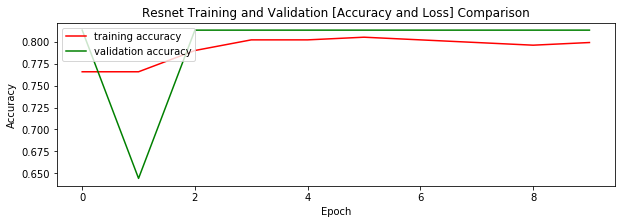

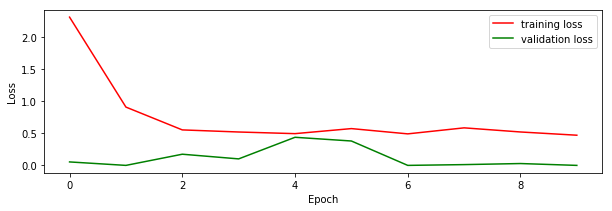

In [62]:
plt.figure(figsize=(10,3))
plt.title('Resnet Training and Validation [Accuracy and Loss] Comparison')
plt.plot(resnet.history['acc'],color='red', label='training accuracy')
plt.plot(resnet.history['val_acc'],color='green', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(resnet.history['loss'],color='red', label='training loss')
plt.plot(resnet.history['val_loss'],color='green', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [63]:
def build_lstm_model2(input_shape=(300,256,256,1)):
    inp=keras.layers.Input(input_shape)
    out1=keras.layers.Conv3D(32,3,activation='relu',padding='same')(inp)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.MaxPooling3D((1,2,2))(out)
    out1=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling3D()(out)
    out=keras.layers.Dense(1,activation='sigmoid')(out)

    model2=keras.models.Model(input=inp,output=out)
    return model2

#next phase
def unet(input_size = (32,32,1),descr=1,classes=1,activation='sigmoid'):
    #descr=2
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = keras.layers.Conv2D(classes*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = keras.layers.Conv2D(classes, 1, activation = activation)(conv9)

    model2= keras.models.Model(input = inputs, output = conv10)
    return model2
#next Phase

def build_lstm_model2(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    
    unet_back=unet(input_size = input_shape,descr=8,classes=3,activation='relu')
    back=keras.applications.googlenet.GoogleNet(input_shape=input_shape,pooling='avg',include_top=False,weights=None)
    back.load_weights('/kaggle/input/google-net/googlenet_weights.h5')
    out=unet_back(inp)
    out=back(out)
    out=keras.layers.Dense(32,activation='relu')(out)
    out=keras.layers.Dropout(0.5)(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model2=keras.models.Model(input=inp,output=out)
    return model2

#Next Phase
def build_lstm_model2(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=input_shape,include_top=False,weights=None,pooling='avg')
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
    out=back(inp)

    out=keras.layers.Dense(16,activation='relu')(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model2=keras.models.Model(input=inp,output=out)
    return model2

#Next Phase
def build_lstm_model2(input_shape=(None,256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=(256,256,3),include_top=False,weights=None,pooling=None)
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
    out=keras.layers.TimeDistributed(back)(inp)
    out1=keras.layers.ConvLSTM2D(256,3,activation='relu')(out)
    out2=keras.layers.ConvLSTM2D(128,3,go_backwards=True,activation='relu')(out)
    out=keras.layers.concatenate([out1,out2])
    out=keras.layers.GlobalAveragePooling2D()(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model2=keras.models.Model(input=inp,output=out)
    return model2

#Next Phase
model2=build_lstm_model2()

#Next Phase
model2.summary()

#Next Phase
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

#Next Phase
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

google=model2.fit_generator(gen,validation_data=val,verbose=1,epochs=10,callbacks=[check])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:106: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None, 256, 25 0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, None, 8, 8, 1 4049564     input_8[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)     (None, 6, 6, 256)    14156800    time_distributed_3[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)     (None, 6, 6, 128)    6488576     time_distributed_3[0][0]         
____________________________________________________________________________________________

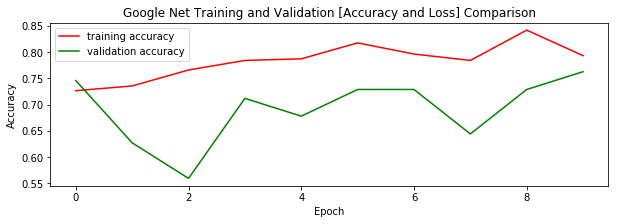

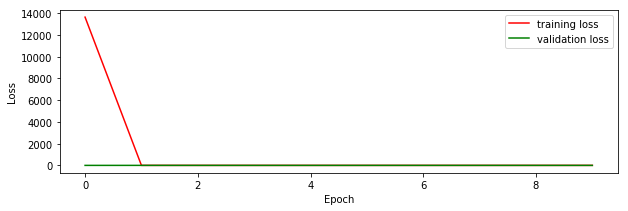

In [64]:
plt.figure(figsize=(10,3))
plt.title('Google Net Training and Validation [Accuracy and Loss] Comparison')
plt.plot(google.history['acc'],color='red', label='training accuracy')
plt.plot(google.history['val_acc'],color='green', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(google.history['loss'],color='red', label='training loss')
plt.plot(google.history['val_loss'],color='green', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [65]:
def build_lstm_model4(input_shape=(300,256,256,1)):
    inp=keras.layers.Input(input_shape)
   
    out1=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.MaxPooling3D((1,2,2))(out)
    out1=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling3D()(out)
    out=keras.layers.Dense(1,activation='sigmoid')(out)

    model4=keras.models.Model(input=inp,output=out)
    return model4

#next phase
def unet(input_size = (32,32,1),descr=1,classes=1,activation='sigmoid'):
    #descr=2
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = keras.layers.Conv2D(classes*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = keras.layers.Conv2D(classes, 1, activation = activation)(conv9)
    #conv10=tf.keras.layers.Attention()(conv10)
    
    model4= keras.models.Model(input = inputs, output = conv10)
    
 
    return model4
#next Phase

def build_lstm_model4(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    
    unet_back=unet(input_size = input_shape,descr=8,classes=3,activation='relu')
    back=keras.applications.vgg.VGG(input_shape=input_shape,pooling='avg',include_top=False,weights=None)
    back.load_weights('/kaggle/input/pre-trained-models/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
    out=unet_back(inp)
    out=back(out)
   
    
    out=keras.layers.Dense(8,activation='relu')(out)
    out=keras.layers.Dropout(0.5)(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model4=keras.models.Model(input=inp,output=out)
    return model4

#Next Phase
def build_lstm_model4(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=input_shape,include_top=False,weights=None,pooling='avg')
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
    #back.trainable = False
    out=back(inp)
    out=keras.layers.Dense(8,activation='relu')(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model4=keras.models.Model(input=inp,output=out)
    return model4

#Next Phase
def build_lstm_model4(input_shape=(None,256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=(256,256,3),include_top=False,weights=None,pooling=None)
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
    
    out=keras.layers.TimeDistributed(back)(inp)
    
    out1=keras.layers.ConvLSTM2D(256,3,activation='relu')(out)
    out2=keras.layers.ConvLSTM2D(128,3,go_backwards=True,activation='relu')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling2D()(out)
    
    out=keras.layers.Dense(2,activation='softmax')(out)

    model4=keras.models.Model(input=inp,output=out)
    return model4

#Next Phase
model4=build_lstm_model4()

#Next Phase
model4.summary()

#Next Phase
model4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

#Next Phase
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

resnet50=model4.fit_generator(gen,validation_data=val,verbose=1,epochs=10,callbacks=[check])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:161: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, None, 256, 25 0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, None, 8, 8, 1 4049564     input_10[0][0]                   
__________________________________________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)     (None, 6, 6, 256)    14156800    time_distributed_4[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)     (None, 6, 6, 128)    6488576     time_distributed_4[0][0]         
____________________________________________________________________________________________

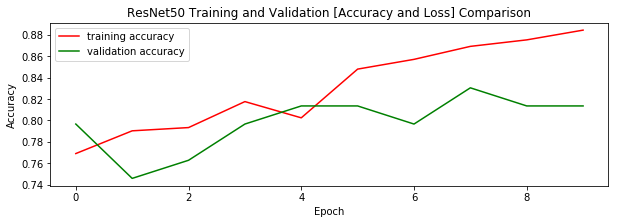

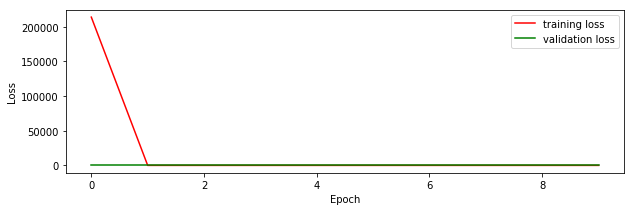

In [66]:
plt.figure(figsize=(10,3))
plt.title('ResNet50 Training and Validation [Accuracy and Loss] Comparison')
plt.plot(resnet50.history['acc'],color='red', label='training accuracy')
plt.plot(resnet50.history['val_acc'],color='green', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(resnet50.history['loss'],color='red', label='training loss')
plt.plot(resnet50.history['val_loss'],color='green', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [67]:
def build_lstm_model5(input_shape=(300,256,256,1)):
    inp=keras.layers.Input(input_shape)
    #out1=keras.layers.ConvLSTM2D(16,3,return_sequences=True,activation='relu',padding='same')(inp)
    #out2=keras.layers.ConvLSTM2D(16,3,return_sequences=True,activation='relu',padding='same')(inp)
   # out=keras.layers.concatenate([out1,out2])

    #print(out.shape)
    #out=keras.layers.MaxPooling3D((1,2,2))(inp)
    out1=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.MaxPooling3D((1,2,2))(out)
    out1=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling3D()(out)
    out=keras.layers.Dense(1,activation='sigmoid')(out)

    model5=keras.models.Model(input=inp,output=out)
    return model5

#next phase
def unet(input_size = (32,32,1),descr=1,classes=1,activation='sigmoid'):
    #descr=2
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = keras.layers.Conv2D(classes*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = keras.layers.Conv2D(classes, 1, activation = activation)(conv9)
  
    model5= keras.models.Model(input = inputs, output = conv10)

    return model5
#next Phase

def build_lstm_model5(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    
    unet_back=unet(input_size = input_shape,descr=8,classes=3,activation='relu')
    back=keras.applications.vgg.VGG(input_shape=input_shape,pooling='avg',include_top=False,weights=None)
    back.load_weights('/kaggle/input/pre-trained-models/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
    out=unet_back(inp)
    out=back(out)
   
    
    out=keras.layers.Dense(8,activation='relu')(out)
    out=keras.layers.Dropout(0.5)(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model5=keras.models.Model(input=inp,output=out)
    return model5

#Next Phase
def build_lstm_model5(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=input_shape,include_top=False,weights=None,pooling='avg')
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
    #back.trainable = False
    out=back(inp)
   
    out=keras.layers.Dense(8,activation='relu')(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model5=keras.models.Model(input=inp,output=out)
    return model5

#Next Phase
def build_lstm_model5(input_shape=(None,256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=(256,256,3),include_top=False,weights=None,pooling=None)
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
    #back.trainable = False
   
    
    out=keras.layers.TimeDistributed(back)(inp)
    
    out1=keras.layers.ConvLSTM2D(256,3,activation='relu')(out)
    out2=keras.layers.ConvLSTM2D(128,3,go_backwards=True,activation='relu')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling2D()(out)
    
    out=keras.layers.Dense(2,activation='softmax')(out)

    model5=keras.models.Model(input=inp,output=out)
    return model5

#Next Phase
model5=build_lstm_model5()

#Next Phase
model5.summary()

#Next Phase
model5.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

#Next Phase
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

vgg16=model5.fit_generator(gen,validation_data=val,verbose=1,epochs=10,callbacks=[check])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:161: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, None, 256, 25 0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, None, 8, 8, 1 4049564     input_12[0][0]                   
__________________________________________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)     (None, 6, 6, 256)    14156800    time_distributed_5[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D)    (None, 6, 6, 128)    6488576     time_distributed_5[0][0]         
____________________________________________________________________________________________

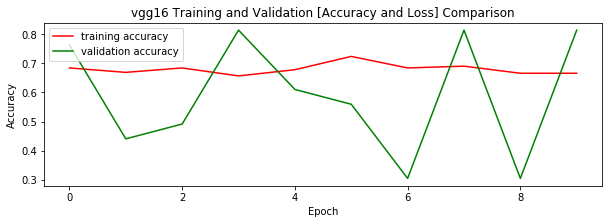

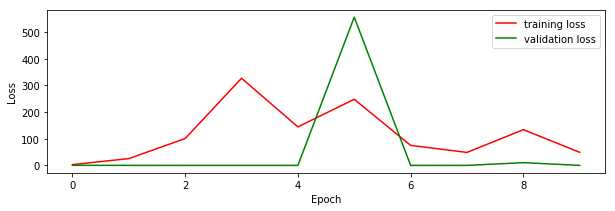

In [68]:
plt.figure(figsize=(10,3))
plt.title('vgg16 Training and Validation [Accuracy and Loss] Comparison')
plt.plot(vgg16.history['acc'],color='red', label='training accuracy')
plt.plot(vgg16.history['val_acc'],color='green', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(vgg16.history['loss'],color='red', label='training loss')
plt.plot(vgg16.history['val_loss'],color='green', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [69]:
def build_lstm_model6(input_shape=(300,256,256,1)):
    inp=keras.layers.Input(input_shape)
   
    out1=keras.layers.Conv3D(32,3,activation='relu',padding='same')(inp)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.MaxPooling3D((1,2,2))(out)
    out1=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling3D()(out)
    out=keras.layers.Dense(1,activation='sigmoid')(out)

    model6=keras.models.Model(input=inp,output=out)
    return model6

#next phase
def unet(input_size = (32,32,1),descr=1,classes=1,activation='sigmoid'):
    #descr=2
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = keras.layers.Conv2D(classes*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = keras.layers.Conv2D(classes, 1, activation = activation)(conv9)
    
    model6= keras.models.Model(input = inputs, output = conv10)
    
    return model6
#next Phase

def build_lstm_model6(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    
    unet_back=unet(input_size = input_shape,descr=8,classes=3,activation='relu')
    back=keras.applications.vgg.VGG(input_shape=input_shape,pooling='avg',include_top=False,weights=None)
    back.load_weights('/kaggle/input/pre-trained-models/vgg19_weights_tf_dim_ordering_tf_kernels.h5')
    out=unet_back(inp)
    out=back(out)
    
    out=keras.layers.Dense(512,activation='relu')(out)
    out=keras.layers.Dropout(0.5)(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model6=keras.models.Model(input=inp,output=out)
    return model6

#Next Phase
def build_lstm_model6(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=input_shape,include_top=False,weights=None,pooling='avg')
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
    #back.trainable = False
    out=back(inp)

    out=keras.layers.Dense(256,activation='relu')(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model6=keras.models.Model(input=inp,output=out)
    return model6

#Next Phase
def build_lstm_model6(input_shape=(None,256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=(256,256,3),include_top=False,weights=None,pooling=None)
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
   
    out=keras.layers.TimeDistributed(back)(inp)
    
    out1=keras.layers.ConvLSTM2D(256,3,activation='relu')(out)
    out2=keras.layers.ConvLSTM2D(128,3,go_backwards=True,activation='relu')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling2D()(out)
   
    out=keras.layers.Dense(2,activation='softmax')(out)

    model6=keras.models.Model(input=inp,output=out)
    return model6

#Next Phase
model6=build_lstm_model6()

#Next Phase
model6.summary()

#Next Phase
model6.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])

#Next Phase
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

vgg19=model6.fit_generator(gen,validation_data=val,verbose=1,epochs=10,callbacks=[check])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:161: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, None, 256, 25 0                                            
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, None, 8, 8, 1 4049564     input_14[0][0]                   
__________________________________________________________________________________________________
conv_lst_m2d_11 (ConvLSTM2D)    (None, 6, 6, 256)    14156800    time_distributed_6[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_12 (ConvLSTM2D)    (None, 6, 6, 128)    6488576     time_distributed_6[0][0]         
____________________________________________________________________________________________

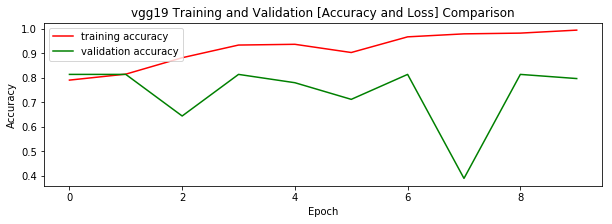

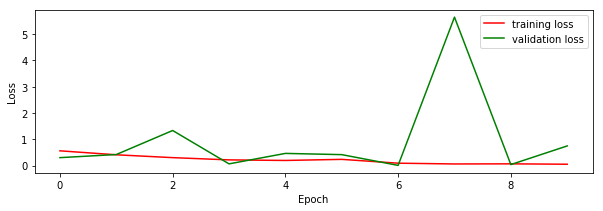

In [70]:
plt.figure(figsize=(10,3))
plt.title('vgg19 Training and Validation [Accuracy and Loss] Comparison')
plt.plot(vgg19.history['acc'],color='red', label='training accuracy')
plt.plot(vgg19.history['val_acc'],color='green', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(vgg19.history['loss'],color='red', label='training loss')
plt.plot(vgg19.history['val_loss'],color='green', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def build_lstm_model7(input_shape=(300,256,256,1)):
    inp=keras.layers.Input(input_shape)
   
    out1=keras.layers.Conv3D(32,3,activation='relu',padding='same')(inp)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(inp)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.MaxPooling3D((1,2,2))(out)
    out1=keras.layers.Conv3D(32,3,activation='relu',padding='same')(out)
    out2=keras.layers.Conv3D(16,3,activation='relu',padding='same')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling3D()(out)
    out=keras.layers.Dense(1,activation='sigmoid')(out)

    model7=keras.models.Model(input=inp,output=out)
    return model7

#next phase
def unet(input_size = (32,32,1),descr=1,classes=1,activation='sigmoid'):
    #descr=2
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = keras.layers.Conv2D(classes*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = keras.layers.Conv2D(classes, 1, activation = activation)(conv9)
   
    model7= keras.models.Model(input = inputs, output = conv10)
    
    return model7
#next Phase

def build_lstm_model7(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    
    unet_back=unet(input_size = input_shape,descr=8,classes=3,activation='relu')
    back=keras.applications.xception.Xception(input_shape=input_shape,pooling='avg',include_top=False,weights=None)
    back.load_weights('/kaggle/input/pre-trained-models/xception_weights_tf_dim_ordering_tf_kernels.h5')
    out=unet_back(inp)
    out=back(out)
    
    out=keras.layers.Dense(8,activation='relu')(out)
    out=keras.layers.Dropout(0.5)(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model7=keras.models.Model(input=inp,output=out)
    return model7

#Next Phase
def build_lstm_model7(input_shape=(256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=input_shape,include_top=False,weights=None,pooling='avg')
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
    #back.trainable = False
    out=back(inp)
 

    out=keras.layers.MaxPooling2D((2,2))(out)
    out1=keras.layers.Conv2D(64,3,activation='relu',padding='same')(out)
    out2=keras.layers.Conv2D(32,3,activation='relu',padding='same')(out)
    out=keras.layers.concatenate([out1,out2])

    
    out=keras.layers.Dense(128,activation='relu')(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model7=keras.models.Model(input=inp,output=out)
    return model7

#Next Phase
def build_lstm_model7(input_shape=(None,256,256,3)):
    inp=keras.layers.Input(input_shape)
    back=efn.EfficientNetB0(input_shape=(256,256,3),include_top=False,weights=None,pooling=None)
    back.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')
   
    out=keras.layers.TimeDistributed(back)(inp)
    
    out1=keras.layers.ConvLSTM2D(16,3,activation='relu')(out)
    out2=keras.layers.ConvLSTM2D(8,3,go_backwards=True,activation='relu')(out)
    out=keras.layers.concatenate([out1,out2])

    out=keras.layers.GlobalAveragePooling2D()(out)
   
    out=keras.layers.Dropout(0.5)(out)
    out=keras.layers.Dense(256,activation='relu')(out)
    out=keras.layers.Dense(2,activation='softmax')(out)

    model7=keras.models.Model(input=inp,output=out)
    return model7

#Next Phase
model7=build_lstm_model7()

#Next Phase
model7.summary()

#Next Phase
model7.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])

#Next Phase
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

xception=model7.fit_generator(gen,validation_data=val,verbose=1,epochs=10,callbacks=[check])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:161: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, None, 256, 25 0                                            
__________________________________________________________________________________________________
time_distributed_9 (TimeDistrib (None, None, 8, 8, 1 4049564     input_20[0][0]                   
__________________________________________________________________________________________________
conv_lst_m2d_17 (ConvLSTM2D)    (None, 6, 6, 16)     746560      time_distributed_9[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_18 (ConvLSTM2D)    (None, 6, 6, 8)      370976      time_distributed_9[0][0]         
___________________________________________________________________________________________

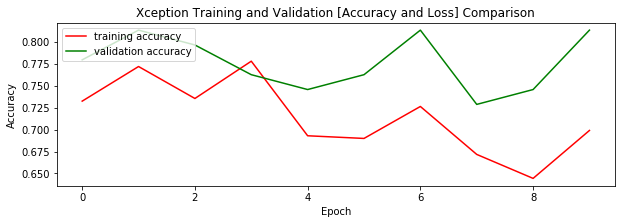

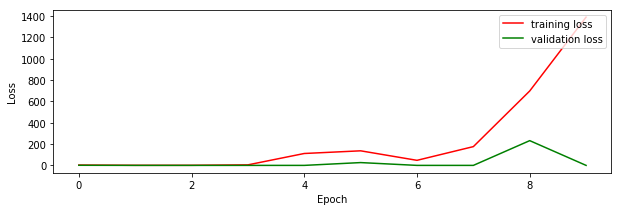

In [72]:
plt.figure(figsize=(10,3))
plt.title('Xception Training and Validation [Accuracy and Loss] Comparison')
plt.plot(xception.history['acc'],color='red', label='training accuracy')
plt.plot(xception.history['val_acc'],color='green', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xception.history['loss'],color='red', label='training loss')
plt.plot(xception.history['val_loss'],color='green', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


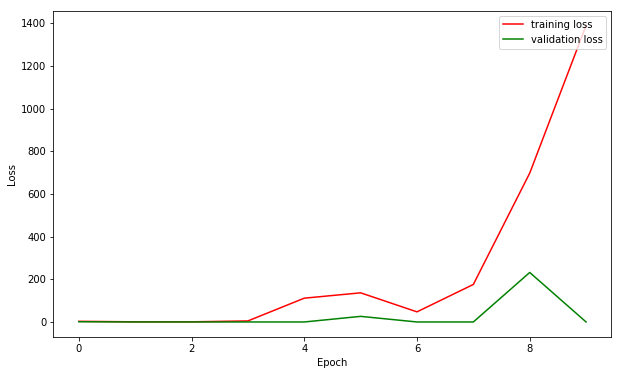

In [73]:
plt.figure(figsize=(10,6))
plt.plot(xception.history['loss'],color='red', label='training loss')
plt.plot(xception.history['val_loss'],color='green', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

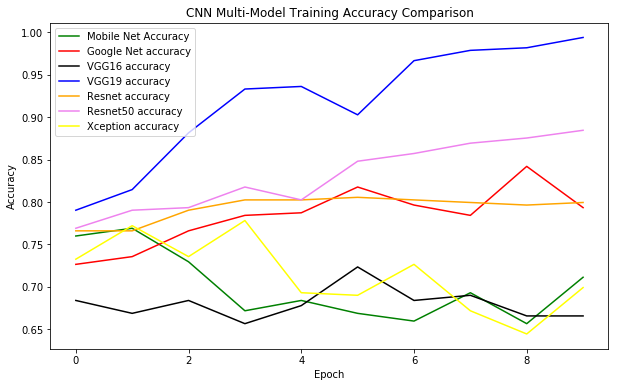

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['acc'], color='green', label='Mobile Net Accuracy')
plt.plot(google.history['acc'], color='red', label='Google Net accuracy')
plt.plot(vgg16.history['acc'], color='black', label='VGG16 accuracy')
plt.plot(vgg19.history['acc'], color='blue', label='VGG19 accuracy')
plt.plot(resnet.history['acc'], color='orange', label='Resnet accuracy')
plt.plot(resnet50.history['acc'], color='violet', label='Resnet50 accuracy')
plt.plot(xception.history['acc'], color='yellow', label='Xception accuracy')
plt.title('CNN Multi-Model Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()


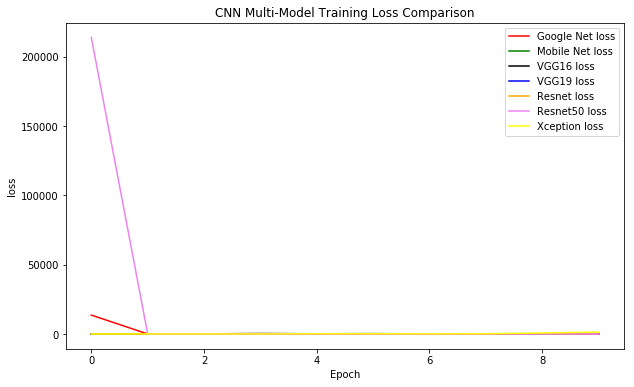

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(google.history['loss'], color='red', label='Google Net loss')
plt.plot(history.history['loss'], color='green', label='Mobile Net loss')
plt.plot(vgg16.history['loss'], color='black', label='VGG16 loss')
plt.plot(vgg19.history['loss'], color='blue', label='VGG19 loss')
plt.plot(resnet.history['loss'], color='orange', label='Resnet loss')
plt.plot(resnet50.history['loss'], color='violet', label='Resnet50 loss')
plt.plot(xception.history['loss'], color='yellow', label='Xception loss')
plt.title('CNN Multi-Model Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()


Evaluate on test data


AttributeError: 'str' object has no attribute 'ndim'

In [76]:
!pip install visualkeras --index-url=https://pypi.python.org/simple/


Looking in indexes: https://pypi.python.org/simple/
ERROR: Could not find a version that satisfies the requirement visualkeras (from versions: none)
ERROR: No matching distribution found for visualkeras


In [77]:
import visualkeras
from PIL import ImageFont
visualkeras.layerd_view(model, legend=true)


ModuleNotFoundError: No module named 'visualkeras'

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layerd_view(google, legend=true)


In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layerd_view(vgg16, legend=true)


In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layerd_view(vgg19, legend=true)


In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layerd_view(xception, legend=true)


In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layerd_view(resnet,legend=true)


In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layerd_view(resnet50, legend=true)
